<a href="https://colab.research.google.com/github/jjklle/capstone/blob/main/RNNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Training**

In [ ]:
data = np.fromfile('/content/drive/MyDrive/이지형/train.f32', dtype='float32')
data=np.reshape(data, (50000000, 87 ))
h5f = h5py.File('train_final.h5', 'w')
h5f.create_dataset('data',data=data)
h5f.close()

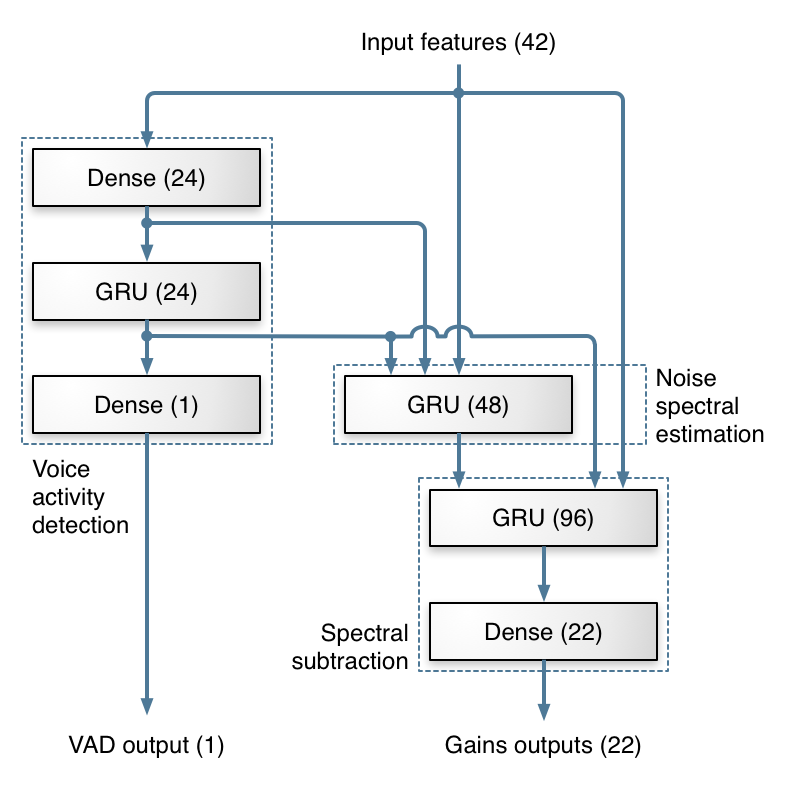

In [ ]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import concatenate
from keras import losses
from keras import regularizers
from keras.constraints import min_max_norm
import h5py

from keras.constraints import Constraint
from keras import backend as K
import numpy as np



def my_crossentropy(y_true, y_pred):
    return K.mean(2*K.abs(y_true-0.5) * K.binary_crossentropy(y_pred, y_true), axis=-1)

def mymask(y_true):
    return K.minimum(y_true+1., 1.)

def msse(y_true, y_pred):
    return K.mean(mymask(y_true) * K.square(K.sqrt(y_pred) - K.sqrt(y_true)), axis=-1)

def mycost(y_true, y_pred):
    return K.mean(mymask(y_true) * (10*K.square(K.square(K.sqrt(y_pred) - K.sqrt(y_true))) + K.square(K.sqrt(y_pred) - K.sqrt(y_true)) + 0.01*K.binary_crossentropy(y_pred, y_true)), axis=-1)

def my_accuracy(y_true, y_pred):
    return K.mean(2*K.abs(y_true-0.5) * K.equal(y_true, K.round(y_pred)), axis=-1)

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, c=2):
        self.c = c

    def __call__(self, p):
        return K.clip(p, -self.c, self.c)

    def get_config(self):
        return {'name': self.__class__.__name__,
            'c': self.c}

reg = 0.000001
constraint = WeightClip(0.499)

print('Build model...')
main_input = Input(shape=(None, 42), name='main_input')
tmp = Dense(24, activation='tanh', name='input_dense', kernel_constraint=constraint, bias_constraint=constraint)(main_input)
vad_gru = GRU(24, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, name='vad_gru', kernel_regularizer=regularizers.l2(reg), recurrent_regularizer=regularizers.l2(reg), kernel_constraint=constraint, recurrent_constraint=constraint, bias_constraint=constraint)(tmp)
vad_output = Dense(1, activation='sigmoid', name='vad_output', kernel_constraint=constraint, bias_constraint=constraint)(vad_gru)
noise_input = keras.layers.concatenate([tmp, vad_gru, main_input])
noise_gru = GRU(48, activation='relu', recurrent_activation='sigmoid', return_sequences=True, name='noise_gru', kernel_regularizer=regularizers.l2(reg), recurrent_regularizer=regularizers.l2(reg), kernel_constraint=constraint, recurrent_constraint=constraint, bias_constraint=constraint)(noise_input)
denoise_input = keras.layers.concatenate([vad_gru, noise_gru, main_input])

denoise_gru = GRU(96, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, name='denoise_gru', kernel_regularizer=regularizers.l2(reg), recurrent_regularizer=regularizers.l2(reg), kernel_constraint=constraint, recurrent_constraint=constraint, bias_constraint=constraint)(denoise_input)

denoise_output = Dense(22, activation='sigmoid', name='denoise_output', kernel_constraint=constraint, bias_constraint=constraint)(denoise_gru)

model = Model(inputs=main_input, outputs=[denoise_output, vad_output])

model.compile(loss=[mycost, my_crossentropy],
              metrics=[msse],
              optimizer='adam', loss_weights=[10, 0.5])


batch_size = 64

print('Loading data...')
with h5py.File('train_final.h5', 'r') as hf:
    all_data = hf['data'][:]
print('done.')

window_size = 2000

nb_sequences = len(all_data)//window_size
print(nb_sequences, ' sequences')
x_train = all_data[:nb_sequences*window_size, :42]
x_train = np.reshape(x_train, (nb_sequences, window_size, 42))

y_train = np.copy(all_data[:nb_sequences*window_size, 42:64])
y_train = np.reshape(y_train, (nb_sequences, window_size, 22))

noise_train = np.copy(all_data[:nb_sequences*window_size, 64:86])
noise_train = np.reshape(noise_train, (nb_sequences, window_size, 22))

vad_train = np.copy(all_data[:nb_sequences*window_size, 86:87])
vad_train = np.reshape(vad_train, (nb_sequences, window_size, 1))

all_data = 0;
#x_train = x_train.astype('float32')
#y_train = y_train.astype('float32')

print(len(x_train), 'train sequences. x shape =', x_train.shape, 'y shape = ', y_train.shape)

print('Train...')
model.fit(x_train, [y_train, vad_train],
          batch_size=batch_size,
          epochs=40,
          validation_split=0.1)
model.save("/content/drive/MyDrive/이지형/공장/weights_final.hdf5")

Build model...


Loading data...
done.
25000  sequences
25000 train sequences. x shape = (25000, 2000, 42) y shape =  (25000, 2000, 22)
Train...
Epoch 1/40
352/352 [==============================] - 1151s 3s/step - loss: 2.7646 - denoise_output_loss: 0.1059 - vad_output_loss: 3.4091 - denoise_output_msse: 0.0386 - vad_output_msse: 0.1919 - val_loss: 1.7548 - val_denoise_output_loss: 0.0592 - val_vad_output_loss: 2.3246 - val_denoise_output_msse: 0.0238 - val_vad_output_msse: 0.1665
Epoch 2/40
352/352 [==============================] - 1140s 3s/step - loss: 1.6370 - denoise_output_loss: 0.0542 - vad_output_loss: 2.1878 - denoise_output_msse: 0.0224 - vad_output_msse: 0.1627 - val_loss: 1.5099 - val_denoise_output_loss: 0.0487 - val_vad_output_loss: 2.0433 - val_denoise_output_msse: 0.0208 - val_vad_output_msse: 0.1530
Epoch 3/40
352/352 [==============================] - 1143s 3s/step - loss: 1.4728 - denoise_output_loss: 0.0474 - vad_output_loss: 1.9967 - denoise_output_msse: 0.0200 - vad_output_msse: 

# **With the trained value, update rnn_data.c File**

In [ ]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.models import load_model
from keras import backend as K
import sys
import re
import numpy as np

def printVector(f, ft, vector, name):
    v = np.reshape(vector, (-1));
    #print('static const float ', name, '[', len(v), '] = \n', file=f)
    f.write('static const rnn_weight {}[{}] = {{\n   '.format(name, len(v)))
    for i in range(0, len(v)):
        f.write('{}'.format(min(127, int(round(256*v[i])))))
        ft.write('{}'.format(min(127, int(round(256*v[i])))))
        if (i!=len(v)-1):
            f.write(',')
        else:
            break;
        ft.write(" ")
        if (i%8==7):
            f.write("\n   ")
        else:
            f.write(" ")
    #print(v, file=f)
    f.write('\n};\n\n')
    ft.write("\n")
    return;

def printLayer(f, ft, layer):
    weights = layer.get_weights()
    activation = re.search('function (.*) at', str(layer.activation)).group(1).upper()
    if len(weights) > 2:
        ft.write('{} {} '.format(weights[0].shape[0], weights[0].shape[1]/3))
    else:
        ft.write('{} {} '.format(weights[0].shape[0], weights[0].shape[1]))
    if activation == 'SIGMOID':
        ft.write('1\n')
    elif activation == 'RELU':
        ft.write('2\n')
    else:
        ft.write('0\n')
    printVector(f, ft, weights[0], layer.name + '_weights')
    if len(weights) > 2:
        printVector(f, ft, weights[1], layer.name + '_recurrent_weights')
    printVector(f, ft, weights[-1], layer.name + '_bias')
    name = layer.name
    if len(weights) > 2:
        f.write('static const GRULayer {} = {{\n   {}_bias,\n   {}_weights,\n   {}_recurrent_weights,\n   {}, {}, ACTIVATION_{}\n}};\n\n'
                .format(name, name, name, name, weights[0].shape[0], weights[0].shape[1]/3, activation))
    else:
        f.write('static const DenseLayer {} = {{\n   {}_bias,\n   {}_weights,\n   {}, {}, ACTIVATION_{}\n}};\n\n'
                .format(name, name, name, weights[0].shape[0], weights[0].shape[1], activation))

def structLayer(f, layer):
    weights = layer.get_weights()
    name = layer.name
    if len(weights) > 2:
        f.write('    {},\n'.format(weights[0].shape[1]/3))
    else:
        f.write('    {},\n'.format(weights[0].shape[1]))
    f.write('    &{},\n'.format(name))


def foo(c, name):
    return None

def mean_squared_sqrt_error(y_true, y_pred):
    return K.mean(K.square(K.sqrt(y_pred) - K.sqrt(y_true)), axis=-1)


model = load_model('/content/drive/MyDrive/이지형/공장/weights_final.hdf5', custom_objects={'msse': mean_squared_sqrt_error, 'mean_squared_sqrt_error': mean_squared_sqrt_error, 'my_crossentropy': mean_squared_sqrt_error, 'mycost': mean_squared_sqrt_error, 'WeightClip': foo})

weights = model.get_weights()

f = open('/content/drive/MyDrive/이지형/공장/rnn_data.c', 'w')
ft = open('/content/drive/MyDrive/이지형/공장/rnn_data', 'w')

f.write('/*This file is automatically generated from a Keras model*/\n\n')
f.write('#ifdef HAVE_CONFIG_H\n#include "config.h"\n#endif\n\n#include "rnn.h"\n#include "rnn_data.h"\n\n')
ft.write('rnnoise-nu model file version 1\n')

layer_list = []
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        printLayer(f, ft, layer)
    if len(layer.get_weights()) > 2:
        layer_list.append(layer.name)

f.write('const struct RNNModel rnnoise_model_{} = {{\n'.format('orig'))
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        structLayer(f, layer)
f.write('};\n')

#hf.write('struct RNNState {\n')
#for i, name in enumerate(layer_list):
#    hf.write('  float {}_state[{}_SIZE];\n'.format(name, name.upper())) 
#hf.write('};\n')

f.close()